In [206]:
import os
import numpy as np
import pandas as pd
from numpy.random import shuffle
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

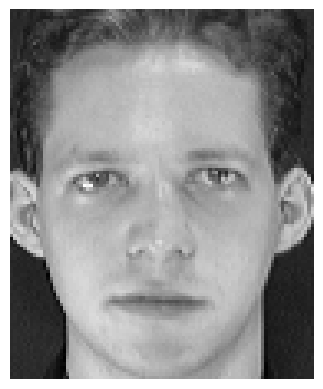

In [207]:
import cv2
import matplotlib.pyplot as plt

def read_pgm(file_path):
    return cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

def show_image(image_data):
    plt.imshow(image_data, cmap='gray')
    plt.axis('off')  # Hide axis labels
    plt.show()

file_path = f'../ATT images/s1/1.pgm'
image_data = read_pgm(file_path)
show_image(image_data)

In [208]:
image_data.shape

(112, 92)

In [209]:
def get_data(path_data='../ATT images', test_size=0.2, is_shuffle=True):
    folders = [f's{i+1}' for i in range(40)]
    X, y = [], []

    for i in range(1, 41):
        path = path_data + f'/s{i}'
        files = os.listdir(path)
        num_files = len(files)

        if is_shuffle:
            files = shuffle(files)

        for file in os.listdir(path):
            path = path_data + f'/s{i}/' + file
            image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            pixels = np.reshape(image, [1, image.shape[0] * image.shape[1]])
            pixels = np.asarray(pixels)

            if len(X) == 0:
                X = pixels
            else:
                X = np.vstack([X, pixels])
            y.append(f's{i}')

    return X, np.asarray(y)

In [210]:
X, y = get_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [211]:
n_components_pca = 50
pca = PCA(n_components=n_components_pca, random_state=42)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

In [212]:
predictions = {}

# Euclidean

In [213]:
y_pred = []
for i in range(80):
    min_ = np.argmin(np.sqrt(np.sum((X_train_reduced - X_test_reduced[i])**2,axis=1)))
    y_pred.append(y_train[min_])

In [214]:
predictions['euclidean'] = y_pred

In [215]:
from sklearn.model_selection import KFold
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

****

**Chọn trường hợp accuracy của logistic model khác 1**

In [216]:
lr = LogisticRegression()
lr.fit(X_train_reduced, y_train)
y_pred = lr.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

accuracy: 0.975
recall: 0.9791666666666666
precision: 0.9837962962962963
f1-score: 0.9772486772486771
roc_auc:  0.9892248954748956


# Random Forest

In [217]:
prediction_results = {}

In [218]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

**Normal**

In [219]:
rfr = RandomForestClassifier(random_state=42)
rfr.fit(X_train_reduced,y_train)
y_pred = rfr.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

accuracy: 0.925
recall: 0.9351851851851851
precision: 0.9097222222222222
f1-score: 0.9089947089947089
roc_auc:  0.7622988574972966


**Tunning**

In [220]:
import optuna

def objective(trial):
        hyperparams = {
            'n_estimators' : trial.suggest_int('n_estimators',100,1000),
            'max_depth' : trial.suggest_int('max_depth',10, 50),
            'min_samples_split' : trial.suggest_int('min_samples_split', 2, 32),
            'random_state' : trial.suggest_categorical('random_state',[42]),
            'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 32),
            'n_jobs' : -1
        }
        
        model = RandomForestClassifier(**hyperparams)
        scores = cross_val_score(model, X_train_reduced, y_train, cv=kf, scoring = 'accuracy')
        return np.mean(scores)

In [221]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

[I 2024-02-16 01:01:51,023] A new study created in memory with name: no-name-fe142963-d986-4846-8133-9b71e3d07e53
[I 2024-02-16 01:01:56,211] Trial 0 finished with value: 0.83125 and parameters: {'n_estimators': 737, 'max_depth': 24, 'min_samples_split': 6, 'random_state': 42, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.83125.
[I 2024-02-16 01:01:59,258] Trial 1 finished with value: 0.628125 and parameters: {'n_estimators': 375, 'max_depth': 12, 'min_samples_split': 28, 'random_state': 42, 'min_samples_leaf': 22}. Best is trial 0 with value: 0.83125.
[I 2024-02-16 01:02:02,870] Trial 2 finished with value: 0.621875 and parameters: {'n_estimators': 412, 'max_depth': 49, 'min_samples_split': 4, 'random_state': 42, 'min_samples_leaf': 23}. Best is trial 0 with value: 0.83125.
[I 2024-02-16 01:02:06,923] Trial 3 finished with value: 0.89375 and parameters: {'n_estimators': 434, 'max_depth': 33, 'min_samples_split': 6, 'random_state': 42, 'min_samples_leaf': 3}. Best is trial 3 wi

Best params found : {'n_estimators': 864, 'max_depth': 23, 'min_samples_split': 4, 'random_state': 42, 'min_samples_leaf': 1}


0.9375

In [222]:
final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['random forest'] = list(y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

accuracy: 0.9375
recall: 0.949074074074074
precision: 0.9611111111111111
f1-score: 0.9430555555555556
roc_auc:  0.9736420986420986


****

# Gassian NB

**Pre-tunning**

In [223]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_reduced, y_train)

y_pred = gnb.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# # ROC AUC score with multiclass handling
# roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovr')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
# print('roc_auc: ', roc_auc_macro)


accuracy: 0.925
recall: 0.9099099099099098
precision: 0.9121621621621622
f1-score: 0.8972972972972973


**Tunning**

In [224]:
def objective(trial):
    hyperparams = {
        'var_smoothing': trial.suggest_float('var_smoothing', 1e-9, 1e-4, log = True)
    }
    
    model = GaussianNB(**hyperparams)
    scores = cross_val_score(model, X_train_reduced, y_train, cv = kf,scoring = 'accuracy')
    return np.mean(scores)

In [225]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = GaussianNB(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['gnb'] = list(y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# # One-hot encoding for probability calculation (adapt if necessary)
# y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
# y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# # ROC AUC score with multiclass handling
# roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
# print('roc_auc: ', roc_auc_macro)

[I 2024-02-16 01:13:09,014] A new study created in memory with name: no-name-e26cbf60-f159-4219-b25f-05d5321abfcd
[I 2024-02-16 01:13:09,044] Trial 0 finished with value: 0.746875 and parameters: {'var_smoothing': 5.886618633764403e-06}. Best is trial 0 with value: 0.746875.
[I 2024-02-16 01:13:09,068] Trial 1 finished with value: 0.746875 and parameters: {'var_smoothing': 1.764059019110879e-05}. Best is trial 0 with value: 0.746875.
[I 2024-02-16 01:13:09,095] Trial 2 finished with value: 0.753125 and parameters: {'var_smoothing': 9.439122097479333e-05}. Best is trial 2 with value: 0.753125.
[I 2024-02-16 01:13:09,120] Trial 3 finished with value: 0.746875 and parameters: {'var_smoothing': 9.434643722776271e-08}. Best is trial 2 with value: 0.753125.
[I 2024-02-16 01:13:09,149] Trial 4 finished with value: 0.746875 and parameters: {'var_smoothing': 7.054484893960037e-08}. Best is trial 2 with value: 0.753125.
[I 2024-02-16 01:13:09,175] Trial 5 finished with value: 0.746875 and parame

Best params found : {'var_smoothing': 9.439122097479333e-05}
accuracy: 0.9375
recall: 0.9166666666666666
precision: 0.9144144144144145
f1-score: 0.9051480051480051


****

# Logistic Regression

**Normal**

In [226]:
lr = LogisticRegression()
lr.fit(X_train_reduced, y_train)
y_pred = lr.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# # One-hot encoding for probability calculation (adapt if necessary)
# y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
# y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# # ROC AUC score with multiclass handling
# roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
# print('roc_auc: ', roc_auc_macro)

accuracy: 0.975
recall: 0.9791666666666666
precision: 0.9837962962962963
f1-score: 0.9772486772486771


**Tunning**

In [227]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

def objective(trial):
    hyperparams = {
        'solver': trial.suggest_categorical('solver', ['lbfgs','liblinear','newton-cg','saga']),
         'penalty': trial.suggest_categorical('penalty',['l2']),
         'multi_class': trial.suggest_categorical('multi_class',['ovr']),
         'C' : trial.suggest_loguniform("C", 1e-3, 1e3),
         'n_jobs' : -1
    }
    
    model = LogisticRegression(**hyperparams)
    scores = cross_val_score(model, X_train_reduced, y_train, cv = kf,scoring = 'accuracy')
    return np.mean(scores)

In [228]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = LogisticRegression(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['logistic regression'] = list(y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

[I 2024-02-16 01:13:11,943] A new study created in memory with name: no-name-769c4ef8-0d5e-4fb6-a566-6708768e5264
[I 2024-02-16 01:13:14,821] Trial 0 finished with value: 0.965625 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 4.381596960168766}. Best is trial 0 with value: 0.965625.
[I 2024-02-16 01:13:18,730] Trial 1 finished with value: 0.93125 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 8.605835697704824}. Best is trial 0 with value: 0.965625.
[I 2024-02-16 01:13:19,211] Trial 2 finished with value: 0.846875 and parameters: {'solver': 'saga', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 14.221826930003898}. Best is trial 0 with value: 0.965625.
[I 2024-02-16 01:13:19,789] Trial 3 finished with value: 0.9625 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 102.71217109002454}. Best is trial 0 with value: 0.965625.
[I 2024-02-16 01:13:20,368] Trial 4 finished with value: 0.975 and p

Best params found : {'solver': 'newton-cg', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 0.006452778457271539}
accuracy: 0.9875
recall: 0.9861111111111112
precision: 0.9907407407407407
f1-score: 0.9851851851851853
roc_auc:  0.9928774928774929


In [229]:
# lr = LogisticRegression(multi_class='ovr', solver='liblinear')
# lr.fit(X_train_reduced, y_train)
# y_pred = lr.predict(X_test_reduced)

# KNN Classifier

**Normal**

In [230]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train_reduced, y_train)
y_pred = knn.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)


accuracy: 0.925
recall: 0.9421296296296295
precision: 0.9495370370370372
f1-score: 0.9279761904761905
roc_auc:  0.9699917551974515


**Tunning**

In [231]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

def objective(trial):
    hyperparams = {
        'n_neighbors': trial.suggest_int("n_neighbors", 5, 100),
        'weights' : trial.suggest_categorical("weights", ["uniform", "distance"]),
        'metric' : trial.suggest_categorical("metric", ["euclidean", "manhattan", "minkowski"]),
        'algorithm':trial.suggest_categorical('algorithm',['auto', 'ball_tree', 'kd_tree', 'brute']),
        'n_jobs': -1
    }
    
    # Create KNN model with tuned hyperparameters
    model = KNeighborsClassifier(**hyperparams)
    scores = cross_val_score(model, X_train_reduced, y_train, cv = kf,scoring = 'accuracy')
    return np.mean(scores)

In [232]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)
best_params = study.best_params
print("Best params found :", best_params)

final_model =KNeighborsClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['KNN'] = list(y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

[I 2024-02-16 01:19:36,546] A new study created in memory with name: no-name-cde9b657-0adb-427f-97db-73491e5080eb
[W 2024-02-16 01:19:36,558] Trial 0 failed with parameters: {'n_neighbors': 97, 'weights': 'uniform', 'metric': 'manhattan', 'algorithm': 'auto'} because of the following error: The value nan is not acceptable.
[W 2024-02-16 01:19:36,560] Trial 0 failed with value nan.
[I 2024-02-16 01:19:36,712] Trial 1 finished with value: 0.05 and parameters: {'n_neighbors': 88, 'weights': 'uniform', 'metric': 'minkowski', 'algorithm': 'ball_tree'}. Best is trial 1 with value: 0.05.
[I 2024-02-16 01:19:36,865] Trial 2 finished with value: 0.584375 and parameters: {'n_neighbors': 95, 'weights': 'distance', 'metric': 'minkowski', 'algorithm': 'ball_tree'}. Best is trial 2 with value: 0.584375.
[I 2024-02-16 01:19:37,020] Trial 3 finished with value: 0.8 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'euclidean', 'algorithm': 'kd_tree'}. Best is trial 3 with value: 0.8

Best params found : {'n_neighbors': 5, 'weights': 'distance', 'metric': 'minkowski', 'algorithm': 'kd_tree'}
accuracy: 0.9375
recall: 0.949074074074074
precision: 0.9564814814814816
f1-score: 0.9393518518518518
roc_auc:  0.9736443526000489


Tuning rồi lưu kết quả tuning vào bên dưới

In [233]:
predictions['lr'] = list(y_pred)

In [236]:
import json
with open("storage/predict_pca_tuning.json", "w") as json_file:
    json.dump(prediction_results, json_file)

In [ ]:
prediction = {}